# Optimizing Spring Computations

This notebook will add specialized computations meant to improve the speed of computing the positions of large systems of springs. The use of the numba package will play a major role in improving the speed of our algorithm. Numba Just In Time compiles our Python functions into machine language that is often much faster than pure Python.

In [68]:
#add the numba library
import numba
from numba import cuda

#type of display for the text section
from IPython.display import display, Math, Latex

#import libraries
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "html5"
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'
from matplotlib import animation, rc
from scipy.integrate import odeint

#magic codes
%matplotlib notebook

First, lets derive the formulas needed to calculate the systems of equations.

The basic idea comes from the use of the Taylor series formula
\begin{equation*}
    x(t+h)=x(t)+hx'(t)+\frac{1}{2!}h^2x''(t)+\frac{1}{3!}h^3x'''(t)+...+\frac{1}{n!}h^nx^{(n)}(t)+...
\end{equation*}
So the next position can be approximated by the derivatives of the position. For example
\begin{equation*}
    x'(t)=x
\end{equation*}
can be solved to find that
\begin{equation*}
    x(t)=e^t+x(0)
\end{equation*}
or using the Talor series formula
\begin{equation*}
    x(t+h)=x(t)+h*x
\end{equation*}
This example is programmed below.

In [69]:
def f_prime(x,t):
    return x

def euler_example(n,a,b):
    h = (b-a)/n
    x = np.e**a
    xs = []
    es = []
    ts = []
    for t in np.linspace(a,b,num=n):
        x = x + h*f_prime(x,t)
        ts.append(t)
        xs.append(x)
        es.append(np.e**t)
    xs = np.array(xs)
    es = np.array(es)
    ts = np.array(ts)
    error = es-xs
    plt.plot(ts,xs, label="computed")
    plt.plot(ts,es, label="exact")
    plt.legend()
    plt.show()
    #plt.plot(ts,error, label="error")
    #plt.legend()
    #plt.show()    

<IPython.core.display.Javascript object>


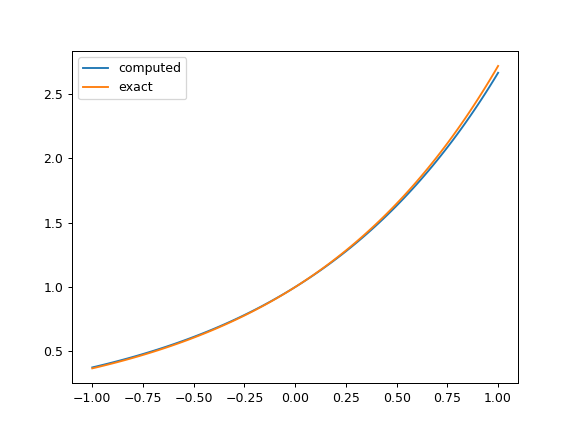

In [71]:
euler_example(100,-1,1)

Now it should be simple to implement our spring systems code from the 2D notebook in a Python function to improve the performace of our algorithm.
Here is an example system:

$X_{xv}=\begin{bmatrix} x_{1x} & x_{1y} & v_{1x} & v_{1y} \\ x_{2x} & x_{2y} & v_{2x} & v_{2y} \\ x_{3x} & x_{3y} & v_{3x} & v_{3y} \end{bmatrix}$
$,\ M=\begin{bmatrix} m_1 \\ m_2 \\ m_3 \end{bmatrix}$

$K=\begin{bmatrix} 0 & k & k \\ k & 0 & k \\ k & k & 0\end{bmatrix}$
$,\ L=\begin{bmatrix} 0 & l_{12} & l_{13} \\ l_{21} & 0 & l_{23} \\ l_{31} & l_{32} & 0\end{bmatrix}$

$D=\begin{bmatrix} 0 & d_{12} & d_{13} \\ d_{21} & 0 & d_{23} \\ d_{31} & d_{32} & 0 \end{bmatrix}$
$,\ d_{xy}=\frac{||\mathbf{x_x}-\mathbf{x_y}||-l_{xy}}{||\mathbf{x_x}-\mathbf{x_y}||}$

$\Delta D=\begin{bmatrix} 0 & \mathbf{x_1}-\mathbf{x_2} & \mathbf{x_1}-\mathbf{x_3} \\ \mathbf{x_2}-\mathbf{x_1} & 0 & \mathbf{x_2}-\mathbf{x_3} \\ \mathbf{x_3}-\mathbf{x_1} & \mathbf{x_3}-\mathbf{x_2} & 0\end{bmatrix}$

In [ ]:
def calculateDiffsBetweenMasses(X_xv):
    rows = X_xv.shape[0]
    columns = d = int(X_xv.shape[1]/2)
    D_L = np.zeros(shape=(rows, columns*rows)) #left distance matrix
    D_R = np.zeros(shape=(rows, columns*rows)) #right distance matrix
    
    for i in range(0, rows):
        for j in range(0, rows):
            D_L[i,d*j:d*j+d] = X_xv[i,0:d]
            D_R[j,d*i:d*i+d] = X_xv[i,0:d]
            
    Delta_D = D_R-D_L
    return Delta_D

In [79]:
D = np.zeros(shape=(3,3))
D[0,1] = 1
D[1,1] = 1
D[2,0] = 1
D[2,2] = 1
D-D.T

array([[ 0.,  1., -1.],
       [-1.,  0.,  0.],
       [ 1.,  0.,  0.]])

In [15]:
def taylor_springs(n,a,b,X,M,K,L,D,F):
    

[1]